# Module 5 Project - EDA & Some Modeling Notebook

In this notebook:
1. Perform train test split
2. Fit some models on all features
3. Drop columns from dataset
4. Fit some more models
5. Perform PCA transformation on a subset of features
6. Fit some more models
7. Drop PCA transformed features and instead use just a few of the originally transformed features instead
8. Fit some more models

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

#from sklearn.feature_selection import SelectKBest, f_classif, chi2

#Sklearn Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.decomposition import PCA

#XGBoost
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb

#MY FUNCTIONS
from mod5project_functions import get_feature_importances, print_model_stats

import pickle #For saving cleaned dataframe to use later

In [2]:
#Read in cleaned data from pickle files here - skip having to run data cleaning cells every time
with open("df.pickle","rb") as f:
    df = pickle.load(f)
    
text_area_cols = df.columns[17:45]
bag_of_words_columns = df.columns[45:156]

In [3]:
X = df.drop(columns=['target'])
y = df.target

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

# Train Test Split

In [38]:
#This will be used to test the cross-validated models
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.15)

# Modeling

### Modeling Function to fit and then print some stats

In [5]:
def fit_model(clf,X_train,X_test,y_train,y_test,
              param_grid,scoring='precision',cv=3,feature_importances=None,title=None):
    """
    This function will fit a model using the provided classifier, dataset, and parameter grid. It uses 
    GridSearchCV to determine the best model.
    
    INPUTS:
    clf                 = Classifier to be fit
    X_train,X_test,y_train,y_test = train/test data to be used 
    param_grid          = Parameter grid to be used for the gridsearch
    scoring             = Scoring method to be used for the gridsearch
    cv                  = Number of cross-validations
    feature_importances = Number of top features to print
    title               = Title to print for clarity when reviewing outputs
    
    OUTPUTS:
    Returns the best estimator model from GridSearch. Prints title, score, feature importances to screen.
    """
    grid_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_clf.fit(X_train,y_train)
    if title:
        print(title)
    print(" BEST PARAMS:")
    print(grid_clf.best_params_)
    print("\nBest", scoring.capitalize() ,"Score:",round(grid_clf.best_score_,4))

    #Get Stats for Train Test Split just to verify that crossvalidation was good.
    print_model_stats(grid_clf,X_train,X_test,y_train,y_test)
    if feature_importances:
        try:
            print("")
            get_feature_importances(grid_clf.best_estimator_, X_train, num_features=feature_importances)
        except:
            pass
    return grid_clf.best_estimator_

### Parameter grids and classifiers to be used later

In [6]:
rf_clf = RandomForestClassifier(max_features='auto')
param_grid_rf = [{'criterion': ['entropy'],
                  'max_depth': [5,6,7,8],
                  'n_estimators': [50,100] }]
#Tested with criterion = 'gini' also but it was never chosen

In [7]:
xgb_clf = xgb.XGBClassifier()
param_grid_xgb = [{'max_depth': [4],
                   'n_estimators': [100],
                   'learning_rate': [0.1, 0.2],
                   'gamma': [0, 1] }]

In [8]:
svc_clf = SVC()
param_grid_svc = [{'C': [1.0],
                   'gamma': ['auto'] }]

## Modeling All Features

#### All Features - Random Forest

In [9]:
fit_model(rf_clf,X_train,X_test,y_train,y_test,param_grid_rf,
          scoring='precision',
          feature_importances=10,
          title="RANDOM FOREST");

RANDOM FOREST
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50}

Best Precision Score: 0.8801
 TRAINING:  Accuracy: 0.9041  Precision: 0.8954
 TEST:      Accuracy: 0.8929  Precision: 0.8941

Feature ranking:
1: Score 0.068, Feature Name: 7
2: Score 0.063, Feature Name: 924
3: Score 0.048, Feature Name: 156
4: Score 0.047, Feature Name: 15
5: Score 0.038, Feature Name: 959
6: Score 0.037, Feature Name: 142
7: Score 0.037, Feature Name: 168
8: Score 0.035, Feature Name: 129
9: Score 0.034, Feature Name: 99
10: Score 0.027, Feature Name: 100


#### All Features - Support Vector Classifier

In [10]:
fit_model(svc_clf,X_train,X_test,y_train,y_test,param_grid_svc,
          scoring='precision',
          feature_importances=10,
          title="SUPPORT VECTOR");

SUPPORT VECTOR
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Precision Score: 0.9011
 TRAINING:  Accuracy: 0.934  Precision: 0.9315
 TEST:      Accuracy: 0.9074  Precision: 0.9112



kbest only

In [11]:
kbest_cols = ['1','5', '10','11','12','13','14','15','16','17','99','100',
              '101','129','156','176','572','762']

#SVC CLASSIFIER
svc = SVC(gamma='auto')
svc.fit(X_train[kbest_cols],y_train)
print("SUPPORT VECTOR")
print_model_stats(svc,X_train[kbest_cols],X_test[kbest_cols],y_train,y_test)

SUPPORT VECTOR
 TRAINING:  Accuracy: 0.8614  Precision: 0.86
 TEST:      Accuracy: 0.8622  Precision: 0.8673


#### All Features - XGBoost

In [12]:
fit_model(xgb_clf,X_train,X_test,y_train,y_test,param_grid_xgb,
          scoring='precision',feature_importances=10,
          title="XGBOOST");

XGBOOST
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

Best Precision Score: 0.9251
 TRAINING:  Accuracy: 0.9455  Precision: 0.9458
 TEST:      Accuracy: 0.9226  Precision: 0.9295

Feature ranking:
1: Score 0.06700000166893005, Feature Name: 104
2: Score 0.041999999433755875, Feature Name: 99
3: Score 0.03400000184774399, Feature Name: 92
4: Score 0.03200000151991844, Feature Name: 102
5: Score 0.03200000151991844, Feature Name: 105
6: Score 0.03099999949336052, Feature Name: 118
7: Score 0.028999999165534973, Feature Name: 4
8: Score 0.027000000700354576, Feature Name: 106
9: Score 0.027000000700354576, Feature Name: 103
10: Score 0.024000000208616257, Feature Name: 17


## Modeling After Dropping Collinear Features

### View Correlation Matrix Again to figure out which columns to drop

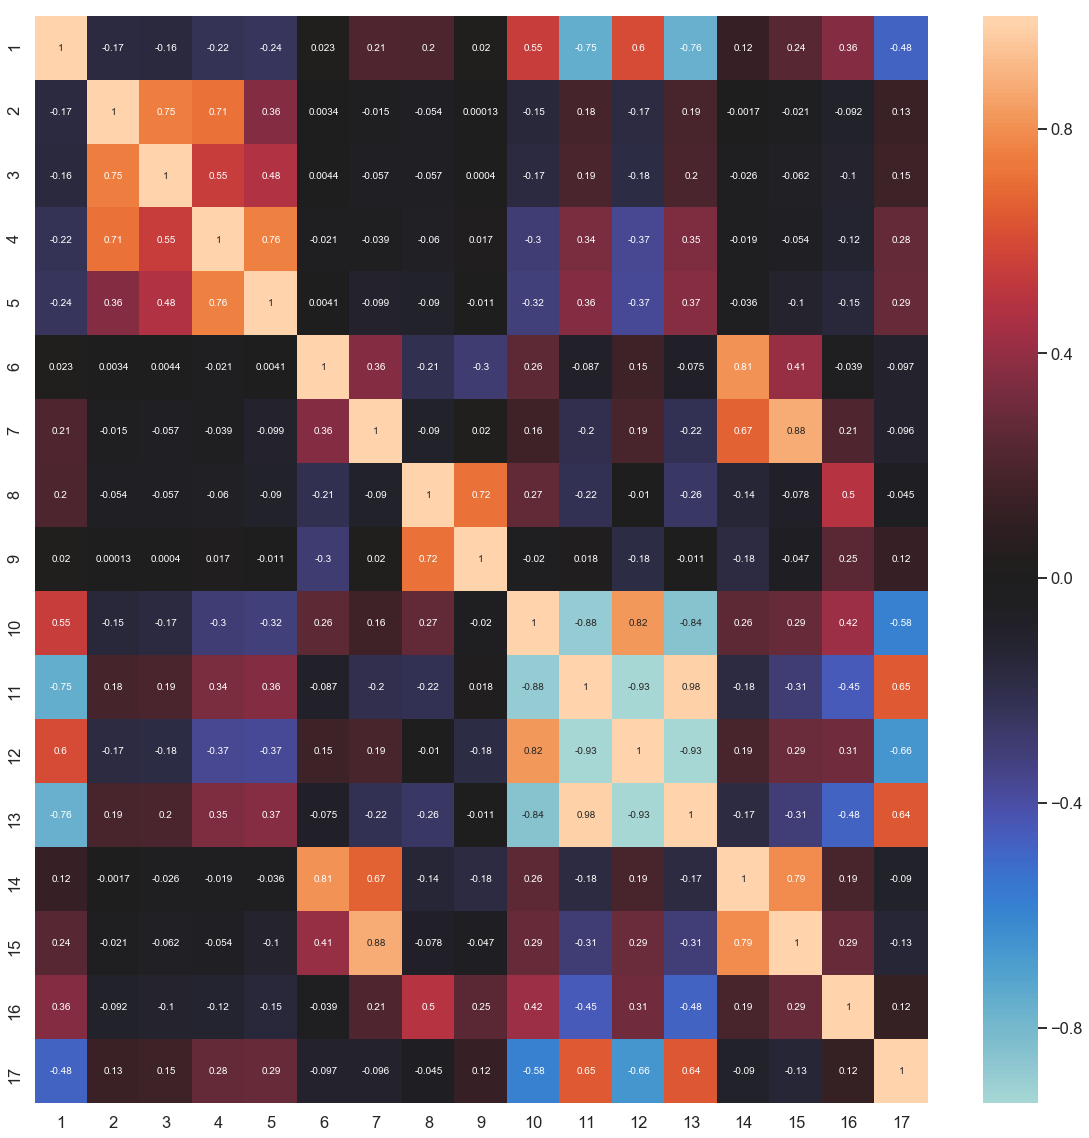

In [13]:
corr = X_scaled[X_scaled.columns[0:17]].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True,center=0)

In [14]:
#Keep 4, drop 2,3,5
#Keep 7, drop 14,15
#Keep 11, drop 10,12,13,17,1
#Keep 8, drop 9, 16
#Drop 4124, 4125 because they are not useful
features_to_drop = ['1','2','3','5','7','9','10','12','13','14','16','17','4124','4125']

X_scaled_dropped = X_scaled.drop(columns=features_to_drop)
X_train_dropped = X_train.drop(columns=features_to_drop)
X_test_dropped = X_test.drop(columns=features_to_drop)

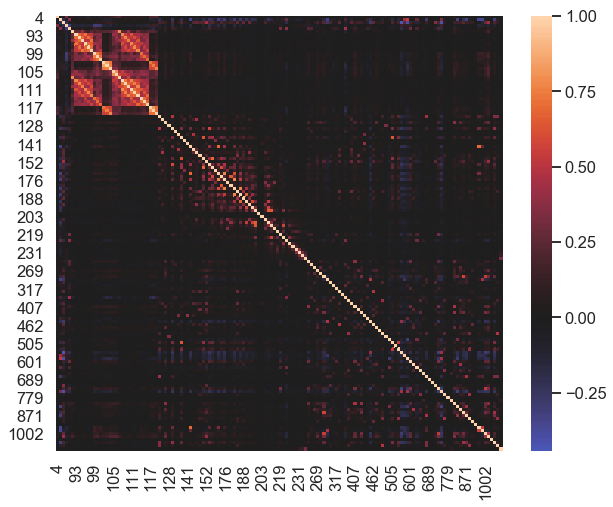

In [15]:
corr = X_scaled_dropped[X_scaled_dropped.columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=False,center=0)

#### Dropped Collinear - Running Models

In [16]:
fit_model(rf_clf,X_train_dropped,X_test_dropped,y_train,y_test,param_grid_rf,
          scoring='precision',
          feature_importances=10,
          title="RANDOM FOREST");
print("\n")
fit_model(xgb_clf,X_train_dropped,X_test_dropped,y_train,y_test,param_grid_xgb,
          scoring='precision',
          feature_importances=10,
          title="XGBOOST");

RANDOM FOREST
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50}

Best Precision Score: 0.8816
 TRAINING:  Accuracy: 0.9036  Precision: 0.8943
 TEST:      Accuracy: 0.8927  Precision: 0.8929

Feature ranking:
1: Score 0.058, Feature Name: 156
2: Score 0.05, Feature Name: 129
3: Score 0.048, Feature Name: 924
4: Score 0.047, Feature Name: 99
5: Score 0.045, Feature Name: 15
6: Score 0.04, Feature Name: 959
7: Score 0.038, Feature Name: 347
8: Score 0.036, Feature Name: 142
9: Score 0.034, Feature Name: 601
10: Score 0.03, Feature Name: 762


XGBOOST
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

Best Precision Score: 0.9245
 TRAINING:  Accuracy: 0.9429  Precision: 0.9422
 TEST:      Accuracy: 0.9227  Precision: 0.929

Feature ranking:
1: Score 0.07500000298023224, Feature Name: 104
2: Score 0.0430000014603138, Feature Name: 92
3: Score 0.04100000113248825, Feature Name: 99
4: Score 0.03400000184774399, Feature Name: 4
5: Sc

# Principal Component Analysis

### PCA - Bag of Words bins

In [17]:
bag_of_words_columns

Index(['123', '125', '127', '128', '129', '130', '131', '134', '137', '141',
       ...
       '882', '886', '924', '959', '1002', '1016', '1028', '1048', '1112',
       '1119'],
      dtype='object', length=111)

In [18]:
pca = PCA()
pca.fit(X_train[bag_of_words_columns])
pca.explained_variance_ratio_.cumsum()

array([0.06531888, 0.10414699, 0.1362405 , 0.16560158, 0.19041383,
       0.21352455, 0.23556971, 0.25521935, 0.2741785 , 0.29182001,
       0.30883355, 0.32523156, 0.34079839, 0.35589695, 0.37071209,
       0.38484019, 0.39856083, 0.41200815, 0.42507595, 0.43780979,
       0.4500582 , 0.46172095, 0.47310413, 0.4843255 , 0.49530381,
       0.50607925, 0.51666484, 0.52716693, 0.53764983, 0.54810662,
       0.55852245, 0.56866189, 0.57877516, 0.58886814, 0.59865315,
       0.60812886, 0.6175572 , 0.62689872, 0.63612895, 0.64533201,
       0.65426363, 0.66305473, 0.67174295, 0.68022913, 0.68868709,
       0.69706229, 0.70520506, 0.71312087, 0.72092713, 0.72869679,
       0.73624927, 0.74366848, 0.750989  , 0.75819206, 0.76529173,
       0.77233353, 0.77929752, 0.78607269, 0.79276237, 0.7994097 ,
       0.8059496 , 0.8123441 , 0.8186547 , 0.82492902, 0.83099158,
       0.83689722, 0.84275909, 0.84860821, 0.85428481, 0.85988153,
       0.86531794, 0.87070658, 0.87602836, 0.88131697, 0.88635

**Gross** The PCA requires 26 features just to get 50% of the variance. I will look into picking out specific word features to see if they will suffice.

In [19]:
bag_of_words_cols_to_keep = ['924','129','156','142','959','168']
drop_cols = bag_of_words_columns.difference(bag_of_words_cols_to_keep)

In [20]:
X_scaled_dropped = X_scaled_dropped.drop(columns=drop_cols)
X_train_dropped = X_train_dropped.drop(columns=drop_cols)
X_test_dropped = X_test_dropped.drop(columns=drop_cols)

### PCA - Text Area bins

In [21]:
text_area_cols

Index(['92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111', '112',
       '113', '114', '115', '116', '117', '118', '119'],
      dtype='object')

In [22]:
pca = PCA()
pca.fit(X_train[text_area_cols])
pca.explained_variance_ratio_.cumsum()

array([0.39119579, 0.5490826 , 0.62757608, 0.69041007, 0.73954536,
       0.78044716, 0.81142278, 0.84135207, 0.8630252 , 0.88375722,
       0.90001779, 0.91551179, 0.92819204, 0.93909518, 0.94798294,
       0.95567277, 0.96290048, 0.9693035 , 0.97503024, 0.98004345,
       0.98410946, 0.98780293, 0.99118172, 0.99393192, 0.99595556,
       0.99758302, 0.99888462, 1.        ])

In [23]:
# Run the PCA algorithm - on training data
n = 5
pca_text_area = PCA(n_components=n)
new_column_names_text_area = [f"PC{n}_text_area" for n in range(1,n+1)]
text_area_transformed = pca_text_area.fit_transform(X_train[text_area_cols])
text_area_transformed = pd.DataFrame(text_area_transformed, 
                                     columns=new_column_names_text_area, 
                                     index=X_train.index)
X_train_PCAed = pd.concat([X_train_dropped,text_area_transformed], axis=1)

Text(0, 0.5, 'Principal Component 2')

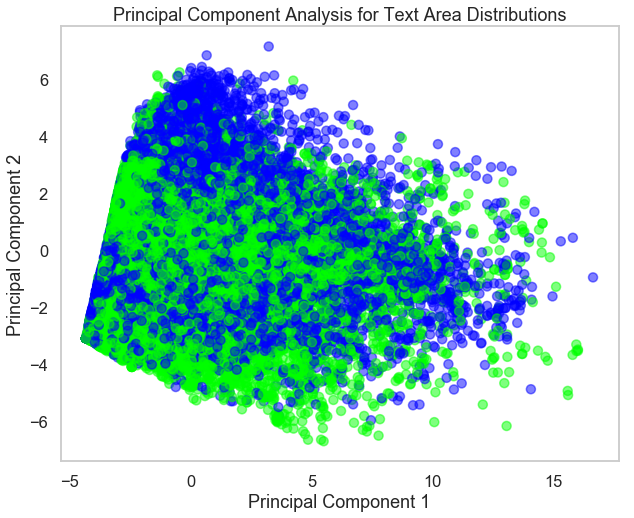

In [24]:
plt.figure(figsize=(10,8))
plt.scatter(text_area_transformed.PC1_text_area,text_area_transformed.PC2_text_area,c=y_train,cmap='brg',alpha=0.5)
plt.grid()
plt.title("Principal Component Analysis for Text Area Distributions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

### Make DataFrame with new PCA columns

In [25]:
#Apply to entire dataset
text_area_transformed = pca_text_area.transform(X_scaled_dropped[text_area_cols])
text_area_transformed = pd.DataFrame(text_area_transformed,
                                     columns=new_column_names_text_area,
                                     index=X_scaled_dropped.index)

X_PCAed = pd.concat([X_scaled_dropped,text_area_transformed], axis=1)

In [26]:
#Apply to test data
text_area_transformed = pca_text_area.transform(X_test_dropped[text_area_cols])
text_area_transformed = pd.DataFrame(text_area_transformed,
                                     columns=new_column_names_text_area,
                                     index=X_test.index)

X_test_PCAed = pd.concat([X_test_dropped,text_area_transformed], axis=1)

In [27]:
#Drop non PCA columns from datasets
X_PCAed.drop(columns=text_area_cols,inplace=True)
X_train_PCAed.drop(columns=text_area_cols,inplace=True)
X_test_PCAed.drop(columns=text_area_cols,inplace=True)

In [28]:
X_PCAed.head()

,4,6,8,11,15,129,142,156,168,924,959,PC1_text_area,PC2_text_area,PC3_text_area,PC4_text_area,PC5_text_area
0,-0.676120,-0.602562,-0.452372,-0.993677,0.514203,-0.424799,-0.418694,-0.403745,-0.380540,-0.255158,0.243531,-0.768202,1.746668,-2.077983,0.063607,0.216386
1,-0.846892,-1.672015,-0.952861,-0.386094,0.282827,0.293383,2.782659,0.266365,3.642433,2.185432,1.987286,-1.592147,1.032560,-1.956096,-0.127656,0.140489
2,-0.244035,-0.175218,-0.376369,-0.864011,1.009587,-0.424799,1.835495,-0.212034,1.293339,1.344404,0.809253,-3.467385,-0.151921,-0.694459,0.046720,-0.153910
3,-0.184755,-0.443291,-0.443157,-0.579656,0.132526,-0.161047,0.304896,0.826904,0.514950,1.034611,0.463108,-3.562937,-0.330229,-0.587984,0.066151,-0.172128
4,-0.156794,1.075573,0.049226,-0.421511,0.050447,-0.424799,-0.418694,-0.403745,-0.380540,-0.460420,-0.525853,-3.560415,-0.398389,-0.623326,-0.028607,-0.185021


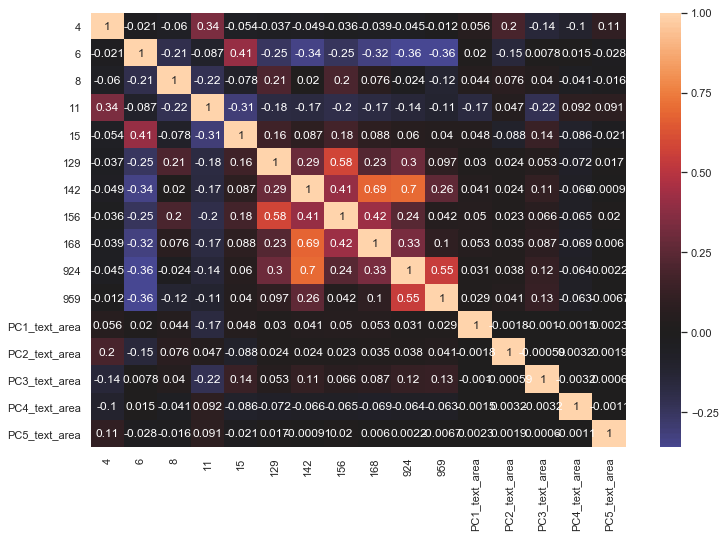

In [29]:
sns.set_context('notebook')
corr = X_PCAed.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr,annot=True,center=0)

### Run Models again with new features

In [30]:
fit_model(rf_clf,X_train_PCAed,X_test_PCAed,y_train,y_test,param_grid_rf,
          scoring='precision',
          feature_importances=10,
          title="RANDOM FOREST");
print("\n")
fit_model(xgb_clf,X_train_PCAed,X_test_PCAed,y_train,y_test,param_grid_xgb,
          scoring='precision',
          feature_importances=10,
          title="XGBOOST");

RANDOM FOREST
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Precision Score: 0.8685
 TRAINING:  Accuracy: 0.8801  Precision: 0.8818
 TEST:      Accuracy: 0.8684  Precision: 0.877

Feature ranking:
1: Score 0.147, Feature Name: 924
2: Score 0.125, Feature Name: 15
3: Score 0.122, Feature Name: PC3_text_area
4: Score 0.103, Feature Name: 156
5: Score 0.077, Feature Name: 129
6: Score 0.074, Feature Name: 959
7: Score 0.062, Feature Name: 142
8: Score 0.061, Feature Name: PC2_text_area
9: Score 0.054, Feature Name: PC4_text_area
10: Score 0.041, Feature Name: 168


XGBOOST
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

Best Precision Score: 0.8901
 TRAINING:  Accuracy: 0.9028  Precision: 0.9076
 TEST:      Accuracy: 0.8851  Precision: 0.8984

Feature ranking:
1: Score 0.12999999523162842, Feature Name: PC2_text_area
2: Score 0.11800000071525574, Feature Name: PC3_text_area
3: Score 0.10999999940395355, Feature Nam

# More GridSearch but with different features

Choosing specific Text Area bins and not using PCA features

In [31]:
text_area_cols_to_keep = ['104','92','99','102','100','118']
drop_cols = text_area_cols.difference(text_area_cols_to_keep)

In [32]:
X_scaled_dropped = X_scaled_dropped.drop(columns=drop_cols)
X_train_dropped = X_train_dropped.drop(columns=drop_cols)
X_test_dropped = X_test_dropped.drop(columns=drop_cols)

In [33]:
X_scaled_dropped.head()

,4,6,8,11,15,92,99,100,102,104,118,129,142,156,168,924,959
0,-0.676120,-0.602562,-0.452372,-0.993677,0.514203,0.378949,-0.808329,-0.788834,0.367341,-0.372898,1.297017,-0.424799,-0.418694,-0.403745,-0.380540,-0.255158,0.243531
1,-0.846892,-1.672015,-0.952861,-0.386094,0.282827,0.262367,-0.808329,-0.839932,0.208655,-0.862171,0.750208,0.293383,2.782659,0.266365,3.642433,2.185432,1.987286
2,-0.244035,-0.175218,-0.376369,-0.864011,1.009587,-0.137991,-0.808329,-0.845314,-0.694760,-1.227174,0.491731,-0.424799,1.835495,-0.212034,1.293339,1.344404,0.809253
3,-0.184755,-0.443291,-0.443157,-0.579656,0.132526,-0.220192,-0.808329,-0.845314,0.025904,-1.425040,0.245372,-0.161047,0.304896,0.826904,0.514950,1.034611,0.463108
4,-0.156794,1.075573,0.049226,-0.421511,0.050447,-0.164781,-0.808329,-0.845314,-0.192336,-1.428239,0.170794,-0.424799,-0.418694,-0.403745,-0.380540,-0.460420,-0.525853


In [34]:
fit_model(rf_clf,X_train_dropped,X_test_dropped,y_train,y_test,
          param_grid_rf,scoring='precision',
          feature_importances=10,
          title="RANDOM FOREST");
print("\n")
fit_model(xgb_clf,X_train_dropped,X_test_dropped,y_train,y_test,
          param_grid_xgb,scoring='precision',
          feature_importances=10,
          title="XGBOOST");

RANDOM FOREST
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Precision Score: 0.8743
 TRAINING:  Accuracy: 0.8939  Precision: 0.8914
 TEST:      Accuracy: 0.8766  Precision: 0.8813

Feature ranking:
1: Score 0.143, Feature Name: 924
2: Score 0.112, Feature Name: 15
3: Score 0.095, Feature Name: 99
4: Score 0.085, Feature Name: 156
5: Score 0.079, Feature Name: 104
6: Score 0.067, Feature Name: 129
7: Score 0.061, Feature Name: 959
8: Score 0.053, Feature Name: 142
9: Score 0.053, Feature Name: 118
10: Score 0.051, Feature Name: 100


XGBOOST
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

Best Precision Score: 0.9021
 TRAINING:  Accuracy: 0.9165  Precision: 0.9184
 TEST:      Accuracy: 0.895  Precision: 0.9046

Feature ranking:
1: Score 0.11599999666213989, Feature Name: 104
2: Score 0.09399999678134918, Feature Name: 92
3: Score 0.08799999952316284, Feature Name: 99
4: Score 0.0860000029206276, Feature Name: 118

### Audio Visual columns only

In [35]:
X_train_dropped.columns[0:5]

Index(['4', '6', '8', '11', '15'], dtype='object')

In [36]:
X_train_audio_visual = X_train_dropped[X_train_dropped.columns[0:5]]
X_test_audio_visual = X_test_dropped[X_test_dropped.columns[0:5]]
X_train_audio_visual.head()

,4,6,8,11,15
14980,0.371573,-0.318321,1.137733,-0.292765,0.720961
19198,-1.095403,1.464465,-0.655877,0.166067,-0.093944
5076,1.040653,-0.903407,1.331931,0.384794,-1.398368
21437,-1.068442,-0.465794,-0.172833,-1.103407,-0.107253
1540,-0.987871,0.327939,-0.552322,1.301906,-0.781643


In [37]:
fit_model(rf_clf,X_train_audio_visual,X_test_audio_visual,y_train,y_test,
          param_grid_rf,scoring='precision',
          feature_importances=10,
          title="RANDOM FOREST");
print("\n")
fit_model(xgb_clf,X_train_audio_visual,X_test_audio_visual,y_train,y_test,
          param_grid_xgb,scoring='precision'
          ,feature_importances=10,
          title="XGBOOST");

RANDOM FOREST
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Precision Score: 0.8134
 TRAINING:  Accuracy: 0.8219  Precision: 0.8259
 TEST:      Accuracy: 0.8048  Precision: 0.8195

Feature ranking:
1: Score 0.433, Feature Name: 15
2: Score 0.222, Feature Name: 11
3: Score 0.179, Feature Name: 6
4: Score 0.099, Feature Name: 8
5: Score 0.067, Feature Name: 4


XGBOOST
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

Best Precision Score: 0.8212
 TRAINING:  Accuracy: 0.8244  Precision: 0.836
 TEST:      Accuracy: 0.8087  Precision: 0.83

Feature ranking:
1: Score 0.21699999272823334, Feature Name: 4
2: Score 0.20800000429153442, Feature Name: 11
3: Score 0.20600000023841858, Feature Name: 8
4: Score 0.1860000044107437, Feature Name: 6
5: Score 0.18299999833106995, Feature Name: 15
